In [1]:
!pip install pandas==1.0.3

     |████████████████████████████████| 10.0 MB 8.9 MB/s 
ERROR: hypertools 0.6.2 has requirement scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.22.2.post1 which is incompatible.
ERROR: datalab 1.1.5 has requirement pandas-profiling==1.4.0, but you'll have pandas-profiling 2.4.0 which is incompatible.
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1


In [2]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from math import log
import lightgbm as lgb
import gc
import shap
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import seaborn as sns

n_classes = 11
folds = 5
SEED_ = 987654321

In [3]:
path = '../input/lgbm-dataset/'

group = np.load(path + 'group.npy', allow_pickle = True)
train_target = pd.read_csv('../input/liverpool-ion-switching/train.csv', usecols = ['open_channels'])
time = pd.read_csv('../input/liverpool-ion-switching/train.csv', usecols = ['open_channels', 'time'])

train = pd.read_csv(path + 'train_clean.csv')

In [4]:
out_ = np.arange(3640000, 3824000)
idx = train.index
bool_mask = idx.isin(out_)
train = train[~idx.isin(out_)].reset_index(drop = True)
group = group[~idx.isin(out_)]
train_target = train_target[~idx.isin(out_)].reset_index(drop = True)


In [5]:
def evaluate_macroF1_lgb(predictions, truth):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    labels = truth.get_label()
    pred_labels = predictions.reshape(n_classes,-1).argmax(axis=0) #np.unique(

    f1 = f1_score(labels, pred_labels, average='macro')
    return ('macroF1', f1, True) 

params = {
        "objective" : "multiclass",
        "num_class" : n_classes,
        'metric' : "None",
        'boosting_type':'gbdt',
        'learning_rate':0.05,
        'colsample_bytree': 0.8,
        'lambda_l1': 1,
        'lambda_l2': 1,
        'max_depth': -1,
        'num_leaves': 2**8,
        'subsample': .75,
        'seed': SEED_,
        'importance_type':'gain',
        'n_jobs':-1,
}

gc.collect()

40

In [6]:
time = pd.read_csv('../input/liverpool-ion-switching/train.csv', usecols = ['open_channels', 'time']).loc[~idx.isin(out_)].reset_index(drop = True)
time['group'] = (time['time'].transform(lambda x: np.ceil(x*10000/500000)))
time['segment'] = train['segment']

In [7]:
strat =time['segment'].astype(str).copy() + time['open_channels'].astype(str).copy()
le = LabelEncoder()
strat = le.fit_transform(strat).astype(np.int16)


In [8]:
del time, le
gc.collect()


20

In [9]:
gc.collect()
kf = GroupKFold(n_splits = folds)
model_list = []
score = 0
pred_oof = np.zeros((train.shape[0], n_classes))

for fold_n, (train_index, valid_index) in enumerate(kf.split(train, strat, group)):
    print(f'BEGIN FOLD:     {fold_n} -------\n\n\n')

    X_train, X_valid = train.iloc[train_index,:], train.iloc[valid_index,:]
    y_train, y_valid = train_target.iloc[train_index,:], train_target.iloc[valid_index,:]

    model = lgb.train(params,lgb.Dataset(X_train, label=y_train, categorical_feature = ['segment']), 
                      5000, valid_sets = lgb.Dataset(X_valid, label=y_valid,categorical_feature = ['segment']), valid_names ='validation',
                      verbose_eval = 50, feval = evaluate_macroF1_lgb, early_stopping_rounds = 50)
    gc.collect()
    
    model_list += [model]
    
    valid_ = model.predict(X_valid)
    pred = valid_.argmax(axis = 1).reshape((-1))
    pred_oof[valid_index, :] = valid_

    score_temp = f1_score(y_valid, pred, average = 'macro')
    score += score_temp/folds

    del model, X_train, X_valid, y_train, y_valid
    gc.collect()
    print(f'\n\nF1_SCORE:  {score_temp}\n\n\nENDED FOLD:     {fold_n} -------\n\n\n')

np.save('pred_oof.npy', pred_oof, allow_pickle = True)

print(f'FINAL F1 SCORE:   {score}')

BEGIN FOLD:     0 -------





Using categorical_feature in Dataset.


Training until validation scores don't improve for 50 rounds
[50]	validation's macroF1: 0.939535
[100]	validation's macroF1: 0.939644
Early stopping, best iteration is:
[77]	validation's macroF1: 0.93972


F1_SCORE:  0.9397199670368884


ENDED FOLD:     0 -------



BEGIN FOLD:     1 -------



Training until validation scores don't improve for 50 rounds
[50]	validation's macroF1: 0.940816
[100]	validation's macroF1: 0.940937
[150]	validation's macroF1: 0.940821
Early stopping, best iteration is:
[110]	validation's macroF1: 0.941044


F1_SCORE:  0.9410435323045522


ENDED FOLD:     1 -------



BEGIN FOLD:     2 -------



Training until validation scores don't improve for 50 rounds
[50]	validation's macroF1: 0.940614
[100]	validation's macroF1: 0.940782
Early stopping, best iteration is:
[87]	validation's macroF1: 0.940847


F1_SCORE:  0.9408471113620522


ENDED FOLD:     2 -------



BEGIN FOLD:     3 -------



Training until validation scores don't improve for 50 rounds
[50]	valida

In [10]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = train.columns


for fold_, mod in tqdm(enumerate(model_list)):
    feature_importances['fold_{}'.format(fold_ + 1)] = mod.feature_importance(importance_type='gain')
    mod.save_model(f'model{fold_}')

Text(0.5, 1.0, '50 TOP feature importance over 5 average')

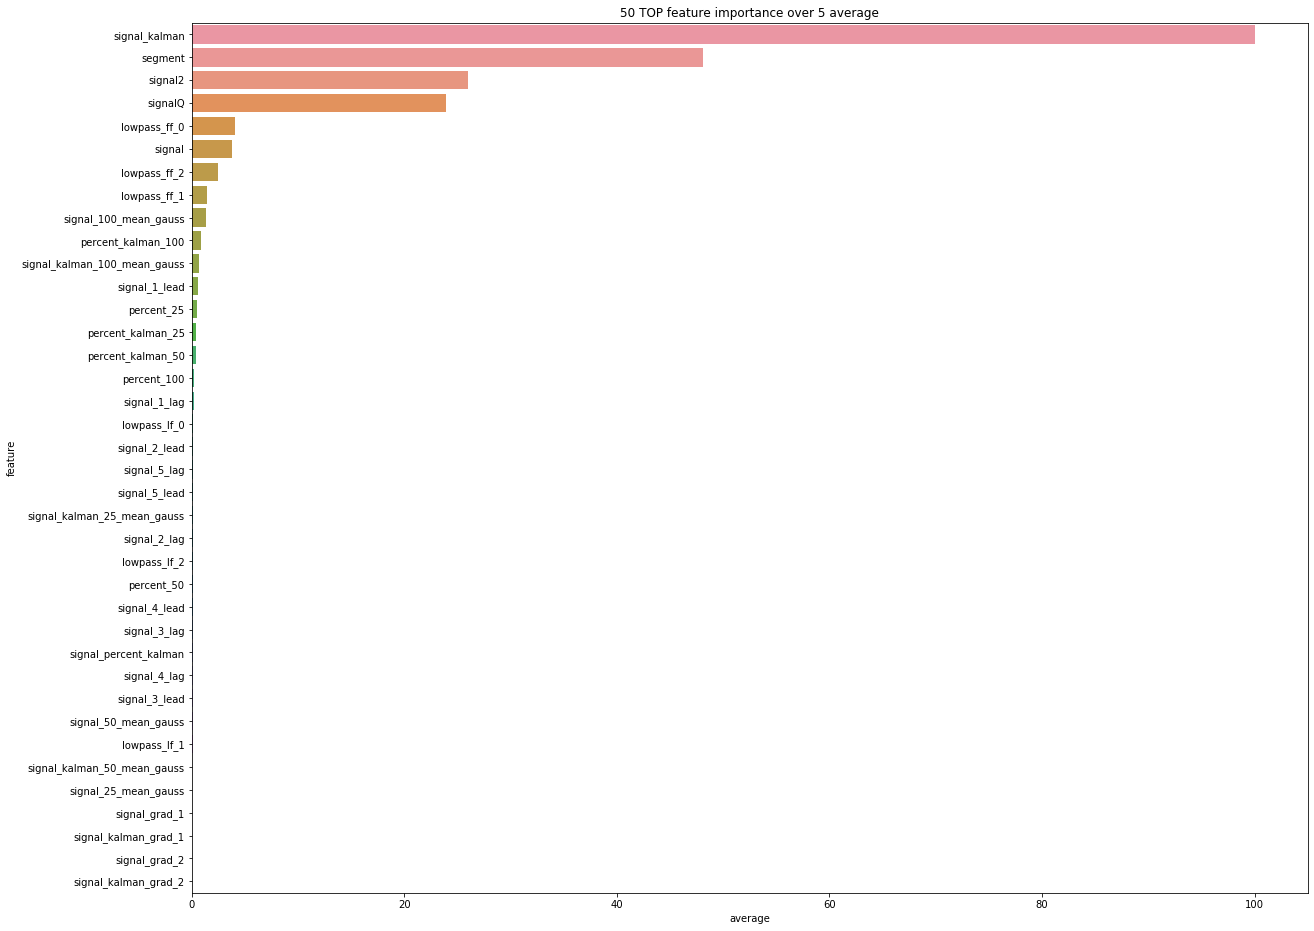

In [11]:
scaler = MinMaxScaler(feature_range=(0, 100))


feature_importances['average'] = scaler.fit_transform(X=pd.DataFrame(feature_importances[['fold_{}'.format(fold + 1) for fold in range(kf.n_splits)]].mean(axis=1)))

fig = plt.figure(figsize=(20, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} average'.format(fold_+1))


In [12]:
del train, train_target
gc.collect()

20

In [13]:
test = pd.read_csv(path + 'test_clean.csv')

for i, mod in enumerate(model_list):
    if i == 0:
        pred_test = mod.predict(test)/folds
    else:
        pred_test += mod.predict(test)/folds


In [14]:
np.save('pred_test.npy', pred_test, allow_pickle = True)
